In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import sklearn
# Used to create training and testing data
from sklearn.model_selection import train_test_split
import umap
from sklearn.model_selection import cross_val_score

#for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

/Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(sklearn.__version__)

1.2.1


# Mediapipe Data Solutions

In [8]:
X = np.load('../export_data/X_data.npy')
y = np.load('../export_data/y_data.npy')

Xmp_train, Xmp_test, ymp_train, ymp_test = train_test_split(X, y, test_size=6*y.shape[1], stratify=y, random_state=40)
X.shape

(221, 151, 258)

In [9]:
print(Xmp_train.shape)
print(Xmp_test.shape)
print(ymp_test.shape)
print(ymp_train.shape)

(167, 151, 258)
(54, 151, 258)
(54, 9)
(167, 9)


In [10]:
mp_full = np.array([features_2d.flatten() for features_2d in X])
Xmp_train2D = np.array([features_2d.flatten() for features_2d in Xmp_train])
Xmp_test2D = np.array([features_2d.flatten() for features_2d in Xmp_test])

## Dimension Reduction

In [11]:
pca = PCA(n_components=12)
pca_train = pca.fit_transform(Xmp_train2D)
pca_test = pca.fit_transform(Xmp_test2D)

#np.save(str( "../export_data/") + 'pca_train', pca_train)
#np.save(str( "../export_data/") + 'y_pca_train', ymp_train)
#np.save(str( "../export_data/") + 'pca_test', pca_test)
#np.save(str( "../export_data/") + 'y_pca_test', ymp_test)

pca_test.shape


(54, 12)

In [56]:
pca_train.shape


(167, 12)

In [57]:
pca_test.shape

(54, 12)

# Visualizing Components

In [31]:
def visualize_labels(features, referenceLabels, isMediaPipeData):
    plt.figure()
    cmap_light = ListedColormap(['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd','#5e4fa2'])
    y = referenceLabels

    if (isMediaPipeData):
        test = ['hvad', 'ja', 'soed', 'mange', 'nej', 'nu', 'fordi', 'koebe', 'tid']
    else:
        test = ['ja', 'hvad', 'nej', 'nu', 'mange', 'fordi', 'koebe', 'tid', 'soed']

    colorind = np.where(y>0)[1]
    print(y.shape)
    scatter = plt.scatter(features[:, 0], features[:, 1], c = colorind, cmap = cmap_light)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.legend(handles=scatter.legend_elements()[0], 
           labels=test,
           title="Signs", loc="best")
    plt.show()
  
    t = 0

(221, 9)


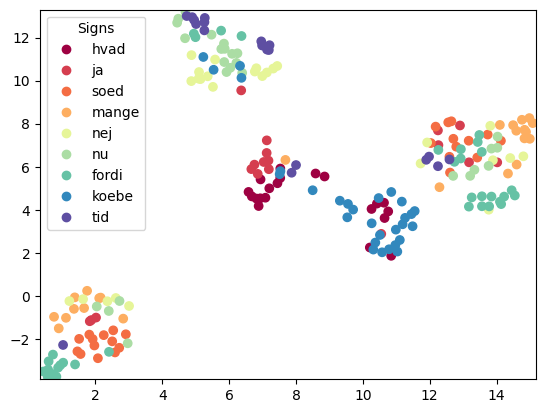

In [32]:
umap_full = umap.UMAP(n_neighbors=12, min_dist=0.5).fit_transform(mp_full)
visualize_labels(umap_full, y, True)

In [170]:
knn_grid_params = { 'n_neighbors' : range(3,15),
                'metric' : ['minkowski','euclidean','manhattan']}

rf_grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 50, 70, 90, 110],
    'n_estimators': range(2, 106, 8)
}

# kNN

## Parameter Fine Tuning 

In [151]:
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_grid_params, verbose = 1, cv=5, n_jobs = -1)
knn_res = knn_gs.fit(Xmp_train2D, ymp_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [152]:
# find the best score
print(knn_res.best_score_)

# get the hyperparameters with the best score
print(knn_res.best_params_)

y_pred = knn_res.predict(Xmp_test2D)
accuracy = accuracy_score(ymp_test, y_pred)
print("Accuracy:", accuracy)

0.6049910873440285
{'metric': 'minkowski', 'n_neighbors': 3}
Accuracy: 0.6481481481481481


In [153]:
knnpca_gs = GridSearchCV(KNeighborsClassifier(), knn_grid_params, verbose = 1, cv=5, n_jobs = -1)
knnpca_res = knnpca_gs.fit(pca_train, ymp_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [154]:
# find the best score
print(knnpca_res.best_score_)

# get the hyperparameters with the best score
print(knnpca_res.best_params_)

y_pred = knnpca_res.predict(pca_test)
accuracy = accuracy_score(ymp_test, y_pred)
print("Accuracy:", accuracy)

0.5877005347593582
{'metric': 'minkowski', 'n_neighbors': 3}
Accuracy: 0.1111111111111111


# Random Forest

## Parameter Fine Tuning

In [171]:
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid = rf_grid_params, cv = 5, n_jobs = -1, verbose = 0)
rf_res = rf_gs.fit(Xmp_train2D, ymp_train)

In [172]:
print(rf_res.best_score_)
print(rf_res.best_params_)
RFy_pred = rf_res.predict(Xmp_test2D)
print("Accuracy:", accuracy_score(ymp_test, RFy_pred))

0.31836007130124777
{'criterion': 'entropy', 'max_depth': 90, 'n_estimators': 42}
Accuracy: 0.42592592592592593


In [173]:
rfpca_gs = GridSearchCV(RandomForestClassifier(), rf_grid_params, verbose = 1, cv=5, n_jobs = -1)
rfpca_res = rfpca_gs.fit(pca_train, ymp_train)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


In [174]:
print(rfpca_res.best_score_)
print(rfpca_res.best_params_)
rfpcay_pred = rfpca_res.predict(pca_test)
print("Accuracy:", accuracy_score(ymp_test, rfpcay_pred))

0.3598930481283423
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 58}
Accuracy: 0.05555555555555555


# VR Solution Data

In [33]:
Xvr = np.load('../VR_exportdata/X_dataVR.npy')
yvr = np.load('../VR_exportdata/y_dataVR.npy')

Xvr_train, Xvr_test, yvr_train, yvr_test = train_test_split(Xvr, yvr, test_size=6*yvr.shape[1], stratify=yvr, random_state=40)
Xvr.shape

(213, 120, 144)

In [35]:
print(Xvr_train.shape)
print(Xvr_test.shape)

(159, 120, 144)
(54, 120, 144)


In [36]:
vr_full = np.array([features_2d.flatten() for features_2d in Xvr])
Xvr_train2D = np.array([features_2d.flatten() for features_2d in Xvr_train])
Xvr_test2D = np.array([features_2d.flatten() for features_2d in Xvr_test])

In [37]:
pca = PCA(n_components=12)
pcavr_train = pca.fit_transform(Xvr_train2D)
pcavr_test = pca.fit_transform(Xvr_test2D)

np.save(str( "../VR_exportdata/") + 'pca_trainVR', pcavr_train)
np.save(str( "../VR_exportdata/") + 'y_pca_trainVR', yvr_train)
np.save(str( "../VR_exportdata/") + 'pca_testVR', pcavr_test)
np.save(str( "../VR_exportdata/") + 'y_pca_testVR', yvr_test)

(213, 9)


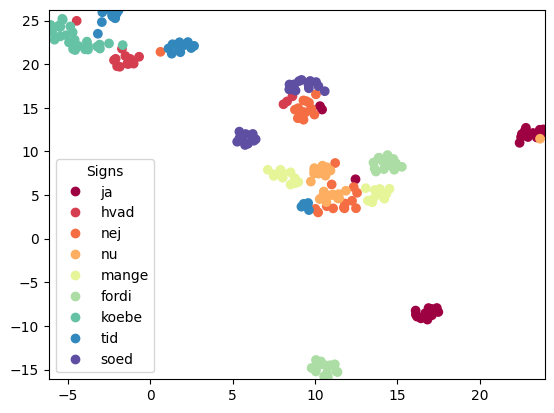

In [46]:
umapvr_full = umap.UMAP(n_neighbors=12, min_dist=0.9).fit_transform(vr_full)
visualize_labels(umapvr_full, yvr, False)

## kNN base Data

In [163]:
knnvr_gs = GridSearchCV(KNeighborsClassifier(), knn_grid_params, verbose = 1, cv=5, n_jobs = -1)
knnvr_res = knnvr_gs.fit(Xvr_train2D, yvr_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [164]:
# find the best score
print(knnvr_res.best_score_)

# get the hyperparameters with the best score
print(knnvr_res.best_params_)

y_pred = knnvr_res.predict(Xvr_test2D)
accuracy = accuracy_score(yvr_test, y_pred)
print("Accuracy:", accuracy)

0.9493951612903226
{'metric': 'manhattan', 'n_neighbors': 3}
Accuracy: 0.9444444444444444


## kNN PCA data

In [165]:
knnpcavr_gs = GridSearchCV(KNeighborsClassifier(), knn_grid_params, verbose = 1, cv=5, n_jobs = -1)
knnpcavr_res = knnpcavr_gs.fit(pcavr_train, yvr_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [166]:
# find the best score
print(knnpcavr_res.best_score_)

# get the hyperparameters with the best score
print(knnpcavr_res.best_params_)

y_pred = knnpcavr_res.predict(pcavr_test)
accuracy = accuracy_score(yvr_test, y_pred)
print("Accuracy:", accuracy)

0.917741935483871
{'metric': 'minkowski', 'n_neighbors': 3}
Accuracy: 0.5185185185185185


# Random Forest

## Base data

In [175]:
rfvr_gs = GridSearchCV(RandomForestClassifier(), param_grid = rf_grid_params, cv = 5, n_jobs = -1, verbose = 0)
rfvr_res = rfvr_gs.fit(Xvr_train2D, yvr_train)

In [178]:
print(rfvr_res.best_score_)
print(rfvr_res.best_params_)
RFy_pred = rfvr_res.predict(Xvr_test2D)
print("Accuracy:", accuracy_score(yvr_test, RFy_pred))

0.9622983870967742
{'criterion': 'entropy', 'max_depth': 70, 'n_estimators': 90}
Accuracy: 0.9629629629629629


## PCA data

In [179]:
rfpcavr_gs = GridSearchCV(RandomForestClassifier(), rf_grid_params, verbose = 1, cv=5, n_jobs = -1)
rfpcavr_res = rfpcavr_gs.fit(pcavr_train, yvr_train)

Fitting 5 folds for each of 130 candidates, totalling 650 fits


In [180]:
print(rfpcavr_res.best_score_)
print(rfpcavr_res.best_params_)
rfpcay_pred = rfpcavr_res.predict(pcavr_test)
print("Accuracy:", accuracy_score(yvr_test, rfpcay_pred))

0.8548387096774194
{'criterion': 'entropy', 'max_depth': 110, 'n_estimators': 58}
Accuracy: 0.14814814814814814
